In [1]:
# import important packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sys.path.insert(0,'../scripts/')
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
df = pd.read_csv("../data/AdSmartABdata.csv")
df_control= pd.read_csv("../data/control_group_data.csv")
df_exposed= pd.read_csv("../data/exposed_clean_data.csv")

In [4]:
df_control['response'].head()

0    1
1    1
2    1
3    1
4    1
Name: response, dtype: int64

In [10]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1


In [5]:
# Dropping observations where there was no response to the presented questionaire
dp = df.query('yes==0 and no==0')
df = df.drop(dp.index)

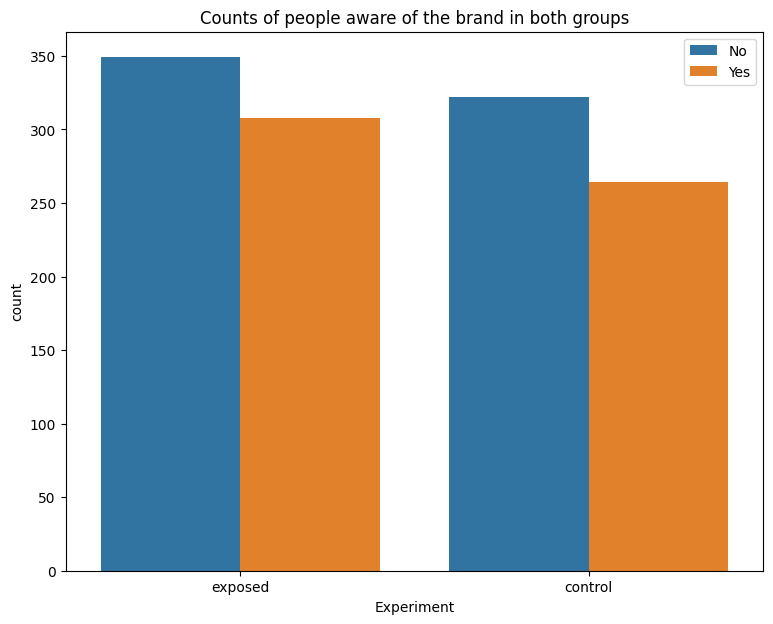

In [8]:
# Counting the people that are aware of the brand in both groups
plt.figure(figsize=(9,7))
axis = sns.countplot(x='experiment', hue='yes', data=df)
axis.set_xlabel('Experiment')
axis.set_ylabel('count')
axis.set_title('Counts of people aware of the brand in both groups')
plt.legend(['No', 'Yes'])


Text(0.5, 1.0, 'Count of Browsers used by the participants')

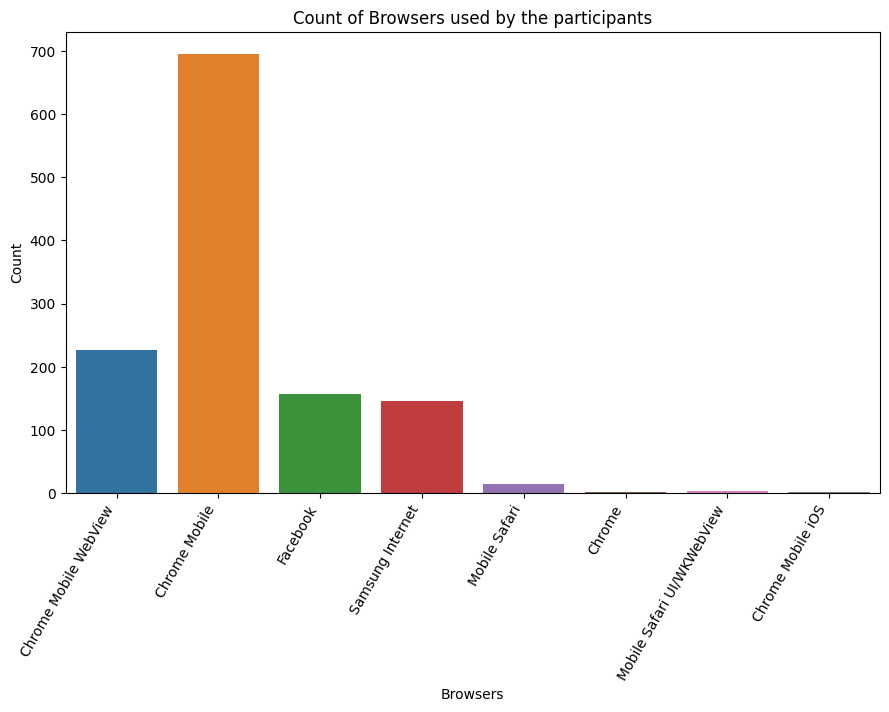

In [9]:
# Count plot of browsrs
plt.figure(figsize=(9,7))
axis = sns.countplot(x='browser', data=df)
axis.set_xticklabels(axis.get_xticklabels(), rotation=60, ha='right')
plt.tight_layout()
axis.set_xlabel('Browsers')
axis.set_ylabel('Count')
axis.set_title('Count of Browsers used by the participants')


Text(0.5, 1.0, 'Distribution fo Hour')

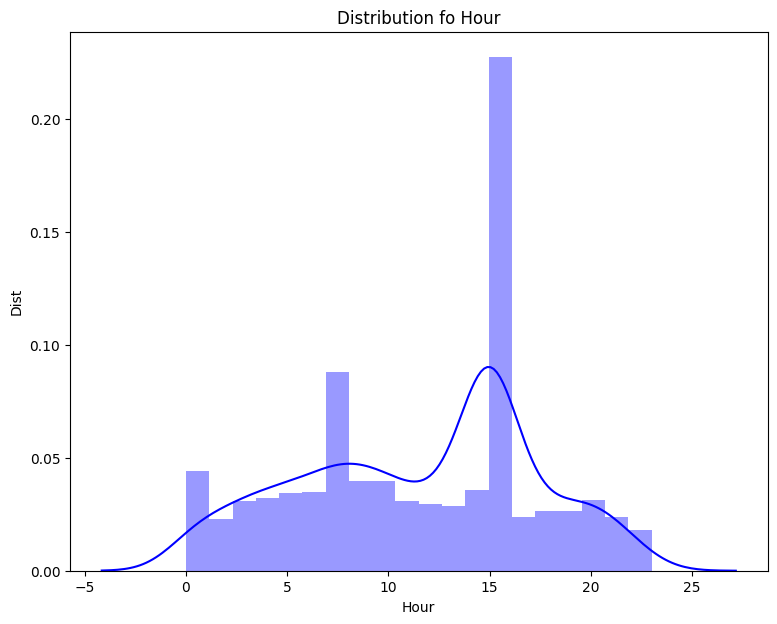

In [13]:
# Distribution of Hour
plt.figure(figsize=(9,7))
axis = sns.distplot(df['hour'],bins=20, color='blue')
axis.set_xlabel('Hour')
axis.set_ylabel('Dist')
#axis.title('Distribution fo Hour')
plt.title('Distribution fo Hour')
